In [1]:
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [35]:
# ## Training a perceptron model on the Iris dataset
# ### Reading-in the Iris data

file_path = 'iris.data'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'iris.data'. First 5 rows:
     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa


In [36]:
def preprocess_data(df):
    # Show initial preview and summary of the data
    print("Initial data preview:")
    print(df.head())
    print("\nData info:")
    print(df.info())

    # Set correct column names
    new_column_names = ['sepal_l', 'sepal_w', 'petal_l', 'petal_w', 'class']
    df.columns = new_column_names

    # Handle missing values: fill numerical columns with median if any missing values exist;
    # if 'class' has missing values, fill them forward.
    if df.isnull().values.any():
        print("Missing values detected. Imputing missing values...")
        numeric_cols = ['sepal_l', 'sepal_w', 'petal_l', 'petal_w']
        for col in numeric_cols:
            df[col].fillna(df[col].median(), inplace=True)
        df['class'].fillna(method='ffill', inplace=True)

    # Binarize the target variable: 'Iris-setosa' -> 1, others -> 0
    df['class'] = df['class'].apply(lambda x: 1 if x == 'Iris-setosa' else 0)

    # Reset index to keep track of the original rows
    df = df.reset_index(drop=True).reset_index().rename(columns={'index': 'original_index'})
    print("\nData after renaming columns and handling missing values:")
    print(df.head())

    # Separate features and target variable
    X = df.drop(columns=['class'])
    y = df[['original_index', 'class']]

    # Standardize the numerical features using StandardScaler
    numeric_cols = ['sepal_l', 'sepal_w', 'petal_l', 'petal_w']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    return X, y

In [37]:
# preprocess the data
X, y = preprocess_data(df)

# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initial data preview:
     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
 1   1       150 non-null    float64
 2   2       150 non-null    float64
 3   3       150 non-null    float64
 4   4       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

Data after renaming columns and handling missing values:
   original_index  sepal_l  sepal_w  petal_l  petal_w  class
0               0      5.1      3.5      1.4      0.2      1
1               1      4.9      3.0      1.4      0.2      1
2               2      4.7      3.2      1.3      0.2      1
3               3      4.6      3.

In [38]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)          
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

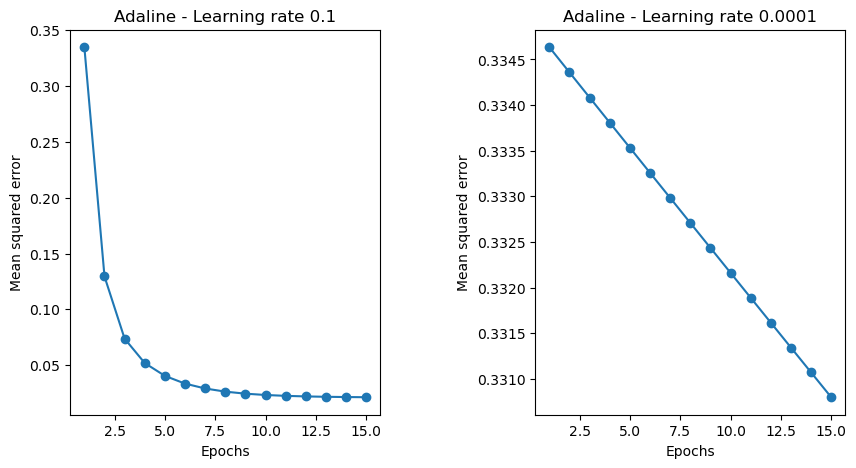

In [39]:
# Train adaptive linear neuron with AdalineGD with 2 different learning rates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# Adjust the horizontal space between subplots
plt.subplots_adjust(wspace=0.5)

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

In [40]:
# predict on trained AdalineGD models

# For the first model (trained with n_iter=15 and eta=0.1)
n_temp1, e_temp1 = 15, 0.1
y_pred = ada1.predict(X_test.loc[:, ['sepal_l','sepal_w','petal_l','petal_w']].values)
print(f"Adaline accuracy with n_iter {n_temp1} and eta {e_temp1}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

# For the second model (trained with n_iter=15 and eta=0.0001)
n_temp2, e_temp2 = 15, 0.0001
y_pred = ada2.predict(X_test.loc[:, ['sepal_l','sepal_w','petal_l','petal_w']].values)
print(f"Adaline accuracy with n_iter {n_temp2} and eta {e_temp2}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

Adaline accuracy with n_iter 15 and eta 0.1: 1.0000
Adaline accuracy with n_iter 15 and eta 0.0001: 0.6667


Adaline accuracy with n_iter 1 and eta 0.1: 0.6667
Adaline accuracy with n_iter 1 and eta 0.01: 0.6667
Adaline accuracy with n_iter 1 and eta 0.001: 0.6667
Adaline accuracy with n_iter 1 and eta 0.0001: 0.6667
Adaline accuracy with n_iter 1 and eta 1e-05: 0.6667
Adaline accuracy with n_iter 5 and eta 0.1: 1.0000
Adaline accuracy with n_iter 5 and eta 0.01: 0.6667
Adaline accuracy with n_iter 5 and eta 0.001: 0.6667
Adaline accuracy with n_iter 5 and eta 0.0001: 0.6667
Adaline accuracy with n_iter 5 and eta 1e-05: 0.6667
Adaline accuracy with n_iter 10 and eta 0.1: 1.0000
Adaline accuracy with n_iter 10 and eta 0.01: 0.6667
Adaline accuracy with n_iter 10 and eta 0.001: 0.6667
Adaline accuracy with n_iter 10 and eta 0.0001: 0.6667
Adaline accuracy with n_iter 10 and eta 1e-05: 0.6667
Adaline accuracy with n_iter 15 and eta 0.1: 1.0000
Adaline accuracy with n_iter 15 and eta 0.01: 0.6667
Adaline accuracy with n_iter 15 and eta 0.001: 0.6667
Adaline accuracy with n_iter 15 and eta 0.0001:

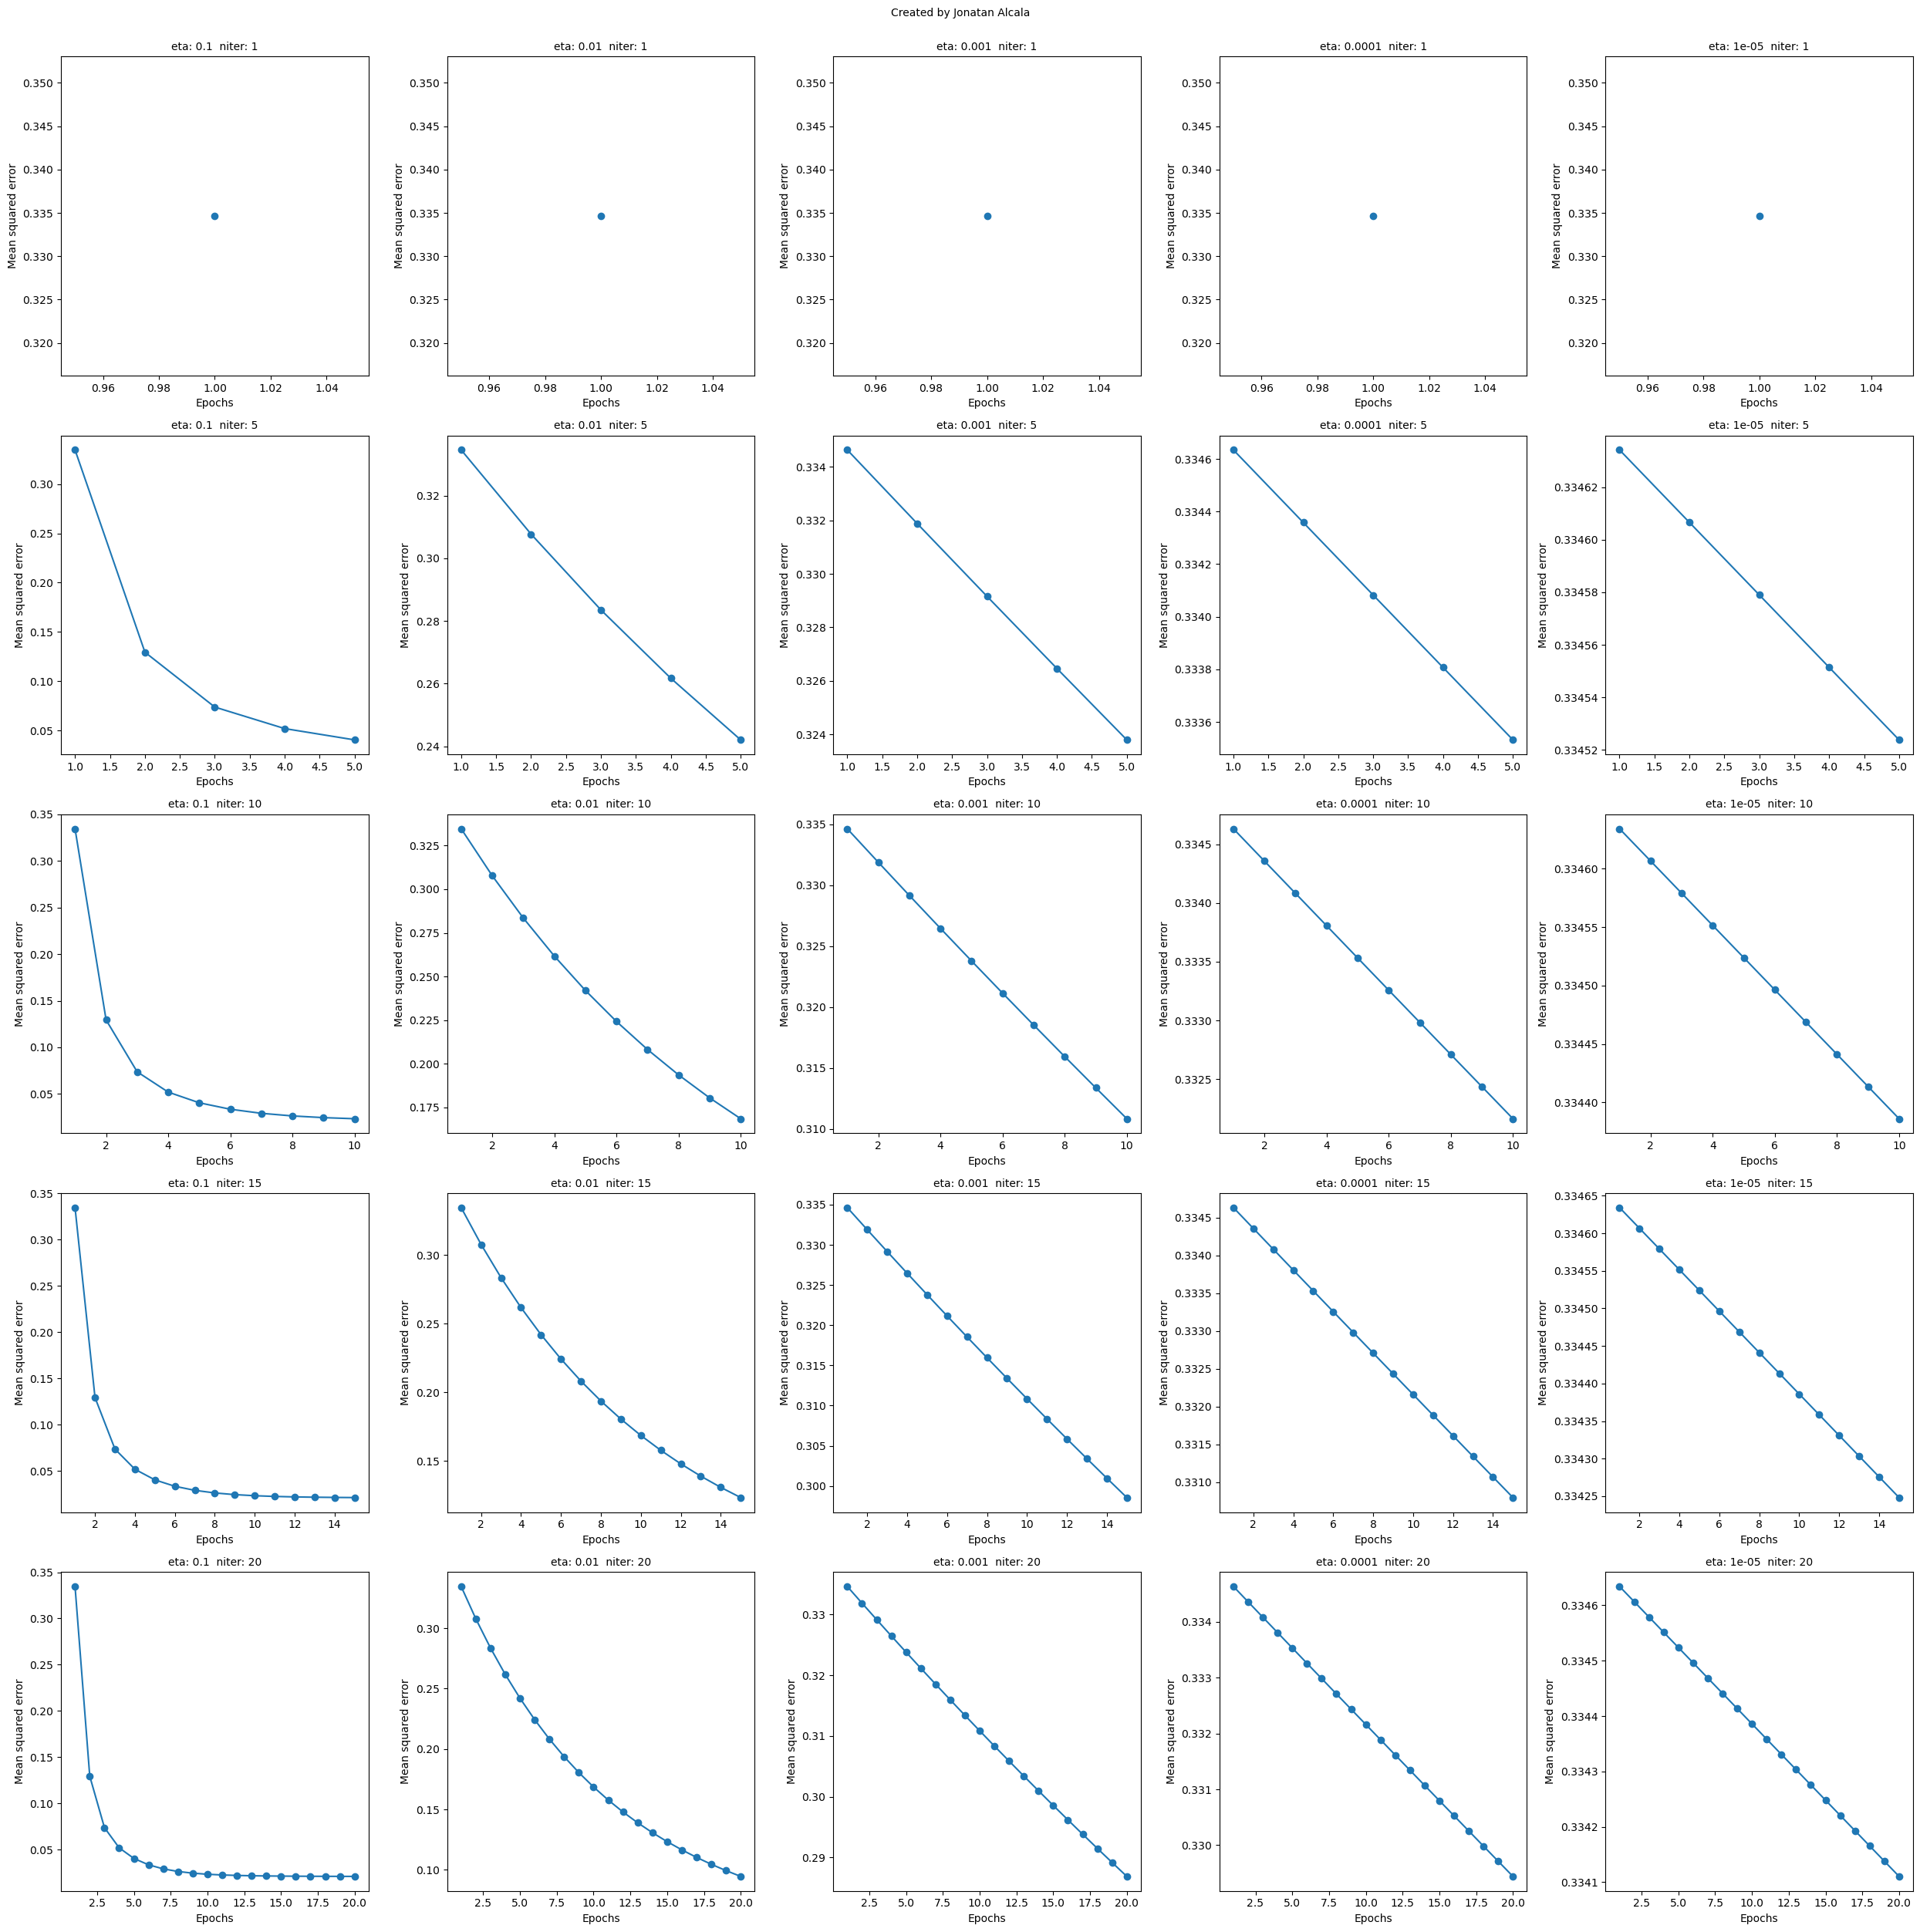

In [41]:
# looking at parameters eta and n_iter
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [1, 5, 10, 15, 20]

fig.suptitle("Created by Jonatan Alcala", fontsize=10, y=1)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineGD(n_iter=n_temp, eta= e_temp).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values)
        print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")
    
plt.tight_layout()
plt.show()

When I examine the AdalineGD results on Iris, I would choose eta (learning rate) of 0.1, as that leads to lower MSE overall when used with different number of n_iter (epochs). As far as the n_iter that would go along with the eta of 0.1, I would select the least number of iterations that would lead to the highest accuracy. Which in this case was n_iter of 5, which lead to a 100% accuracy.

In [42]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

This example shows when we don't suffle the data after each epoch. Shuffling prevents cycles and ensures the model doesn't overfit to the order of the data, leading to better convergence and generalization.

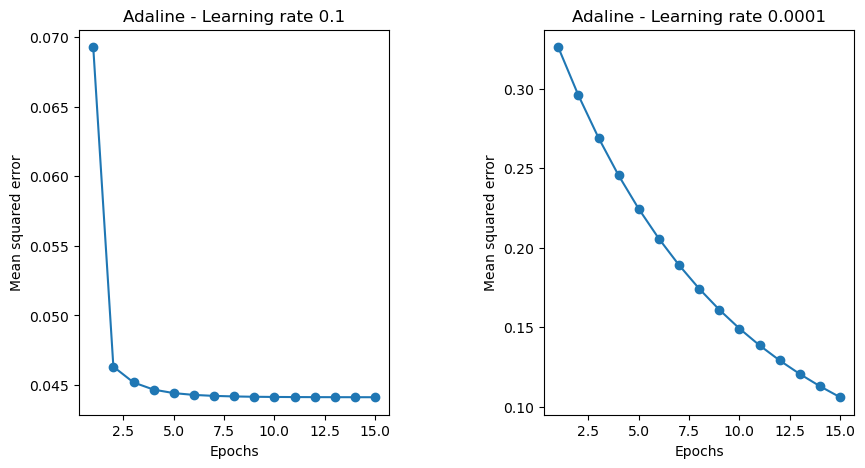

In [43]:
# Train adaptive linear neuron with AdalineSGD with 2 different learning rates.....without shuffling 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ada1 = AdalineSGD(n_iter=15, eta=0.1, shuffle=False).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineSGD(n_iter=15, eta=0.0001, shuffle=False).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# Adjust the horizontal space between subplots
plt.subplots_adjust(wspace=0.5)

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

In [44]:
# predict on trained AdalineSGD models with shuffle FALSE
y_pred =ada1.predict(X_test.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values)
print(f"Adaline accuracy with n_iter 15 and eta 0.1: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

y_pred =ada2.predict(X_test.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values)
print(f"Adaline accuracy with n_iter 15 and eta 0.0001: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

Adaline accuracy with n_iter 15 and eta 0.1: 1.0000
Adaline accuracy with n_iter 15 and eta 0.0001: 0.7000


This example shows what the MSE when we do shuffle the data during each epoch. A you can see the MSE is noiser for the bigger learning rate (0.1), 

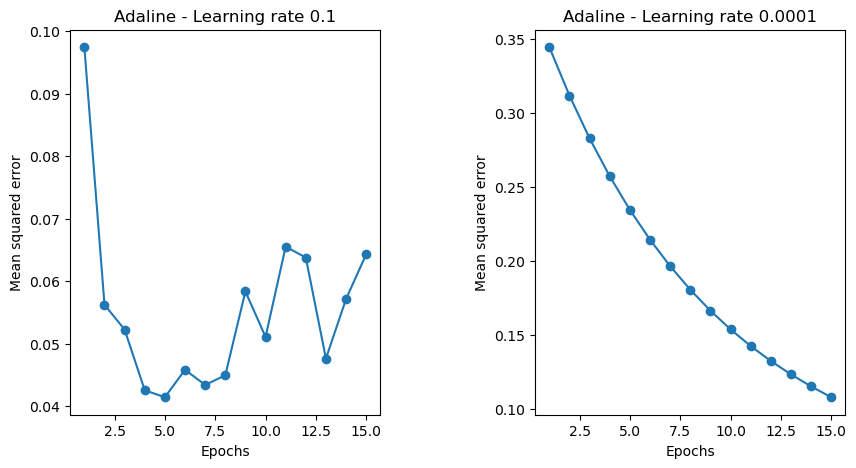

In [45]:
# Train adaptive linear neuron with AdalineSGD with 2 different learning rates.....WITH shuffling 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ada3 = AdalineSGD(n_iter=15, eta=0.1, shuffle=True).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
ax[0].plot(range(1, len(ada3.losses_) + 1), ada3.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.1')

ada4 = AdalineSGD(n_iter=15, eta=0.0001, shuffle=True).fit(X_train.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values, y_train.loc[:,'class'].values)
ax[1].plot(range(1, len(ada4.losses_) + 1), ada4.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# Adjust the horizontal space between subplots
plt.subplots_adjust(wspace=0.5)

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

In [ ]:
# predict on trained AdalineSGD models with shuffle TRUE
y_pred =ada3.predict(X_test.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values)
print(f"Adaline accuracy with n_iter 15 and eta 0.1: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

y_pred =ada4.predict(X_test.loc[:,['sepal_l','sepal_w','petal_l','petal_w']].values)
print(f"Adaline accuracy with n_iter 15 and eta 0.0001: {accuracy_score(y_test.loc[:,'class'].values, y_pred):.4f}")

Adaline accuracy with n_iter 15 and eta 0.1: 1.0000
Adaline accuracy with n_iter 15 and eta 0.0001: 0.7000


Looking at the AdalineSGD results on Iris, shuffling was needed. When looking at the MSE on the AdalineSGD models with a learning rate of 0.1, we see that with shuffling the data is noisier than the model trained without shuffling. This might seem like not shuffling is the best option, but that's not the case. We shuffle because we want to prevent cycles and ensure the model doesn't overfit to the order of the data, which seems like is the case with the model trained without shuffling. The benefits of shuffling would be more apparent if we had a larger dataset. In the case where the models used a learning rate of 0.0001 we didn't see much of a difference in the progression of the MSE, but the step is too small and it would take a lot of epochs for convergence. 